<a href="https://colab.research.google.com/github/nicolaiberk/Imbalanced/blob/master/02b_SMOTE_Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Synthetic Minority Oversampling TEchnique - SMOTE

One way to address imbalanced data problems is to generate additional artificial cases. For example. One method to do this is called **S**ynthetic **M**inority **O**versampling **Te**chnique - or short: **SMOTE**. The full paper can be found [here](https://arxiv.org/abs/1106.1813), a less technical explainer [here](https://www.analyticsvidhya.com/blog/2020/10/overcoming-class-imbalance-using-smote-techniques/) and the scikit-learn documentation on oversampling [here](https://imbalanced-learn.org/stable/over_sampling.html).

We use a highly imbalanced dataset of tweets that were annotated using crowd-coding from [this paper](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3026393). The tweets are classified according to whether they discuss the refugee movements in 2015. We will use the `imblearn` package to implement SMOTE.

We start by importing the packages and loading the data. 

In [1]:
# oversample training samples for crossvalidation
import pandas as pd

# load relevant packages
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression as LogReg
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

# import SMOTE package
from imblearn.over_sampling import SMOTE

tweets = pd.read_csv("https://www.dropbox.com/s/gv56nu1ptrp63ps/annotated_german_refugee_tweets.csv?dl=1")

Divide into training and test set.

In [20]:
# divide into training and test set
X_train, X_test, y_train, y_test = train_test_split(
    tweets.text,
    tweets.annotation,
    test_size=0.20,
    random_state=42
)
X_train = np.array(X_train)
X_test = np.array(X_test)

How imbalanced is the data?

590.0 positive cases out of a full set of 19536 in the training set (3.02%).


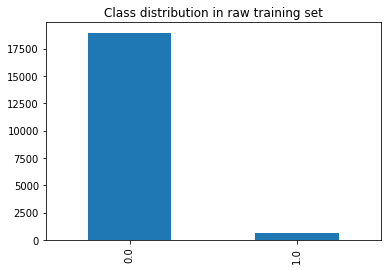

In [21]:
print(f"{sum(y_train)} positive cases out of a full set of {len(y_train)} in the training set ({round(sum(y_train)*100/len(y_train), 2)}%).")
pd.Series(y_train).value_counts().plot(kind='bar', title='Class distribution in raw training set')

Only 3% of the training data belong to the class of interest! Can we fix this by applying SMOTE?

# How does SMOTE work?

Doesn't look great, huh? We could just undersample, meaning we drop cases from the majority class (in this cases tweets *not* about refugees) until we have a balanced data set. However, we would end up with only a fraction of the observations and would lose a lot of information.

SMOTE instead **over**samples the minority class "by taking each minority class sample and introducing synthetic examples along the line segments joining any/all of the k minority class nearest neighbors" (p.328). 

In English: We take one observation in the minority class (in this case tweets) and look for similar minority class observations using a *k-nearest-neighbors* approach (more on this approach [here](https://medium.com/towards-data-science/machine-learning-basics-with-the-k-nearest-neighbors-algorithm-6a6e71d01761)). For a random subset of these similar neighbors, we generate a synthetic observation somewhere in the middle between the original observation and the chosen neighbor (see visualisation below, shamelessly stolen from the scikit-learn documentation).

![](https://imbalanced-learn.org/stable/_images/sphx_glr_plot_illustration_generation_sample_001.png)

# Application

Enough theory, let's just see how this works! First, we need to transform our texts into numbers by translating them into a document-term-matrix. For simplicity, we use the simple count-based matrix here, but you might use tfidf or any other method that produces some number indicating the frequency of a word in a document as well.

In [3]:
# define Vectorizer
vec = TfidfVectorizer() # usually we would add some arguments here
X_train_dtm = vec.fit_transform(X_train)

Now witness the beauty of simplicity:

18946.0 positive cases out of a full set of 37892 in the training set (50.0%).


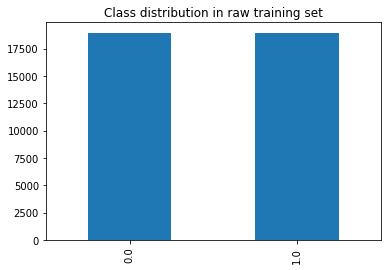

In [14]:
# resample with SMOTE ()
X_resample, y_resample = SMOTE(sampling_strategy = 1).fit_resample(X_train_dtm, y_train)

print(f"{sum(y_resample)} positive cases out of a full set of {len(y_resample)} in the training set ({sum(y_resample)/len(y_resample)*100}%).")
pd.Series(y_resample).value_counts().plot(kind='bar', title='Class distribution in raw training set')

![](https://media3.giphy.com/media/zIwIWQx12YNEI/giphy.gif?cid=ecf05e47yuqbrs13qjl921umf83eb1m4nhnpcstrc38zvcuk&rid=giphy.gif&ct=g)

# Performance

So now we turned our 3% minority class into 50%! (Note: more careful design of this ratio should lead to better results)

Let's see how it performs. First, we train a classifier on the unSMOTE'd, imbalanced data:

In [19]:
# fit
pipe = Pipeline([('tfidf', TfidfVectorizer()), ('LogReg', LogReg())])
pipe.fit(X_train, y_train)

# classify test set and show performance
y_pred_m = pipe.predict(X_test)
print("Accuracy: ", accuracy_score(y_test, y_pred_m).round(2))
print("Recall: ", recall_score(y_test, y_pred_m).round(2))
print("Precision: ", precision_score(y_test, y_pred_m).round(2))
print("F1: ", f1_score(y_test, y_pred_m).round(2))
pd.crosstab(y_test, y_pred_m)

Accuracy:  0.97
Recall:  0.06
Precision:  0.67
F1:  0.11


col_0,0.0,1.0
annotation,,
0.0,4743,4
1.0,129,8


Here we have very good precision, but would only find very few of the cases in the outcome category, which are the ones we care about after all. 

How 'bout SMOTE?

In [22]:
# transform test set
X_test_dtm = vec.transform(X_test) 
## note it's transform, not fit_transform, as we transform it into the same dtm as the training set

# define and fit classifier
lr = LogReg()
lr.fit(X_resample, y_resample)

# predict
y_pred = lr.predict(X_test_dtm)

print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Recall: ", round(recall_score(y_test, y_pred), 2))
print("Precision: ", round(precision_score(y_test, y_pred), 2))
print("F1: ", round(f1_score(y_test, y_pred), 2))
pd.crosstab(y_test, y_pred)

Accuracy:  0.9672399672399672
Recall:  0.67
Precision:  0.44
F1:  0.53


col_0,0.0,1.0
annotation,,
0.0,4632,115
1.0,45,92


We still misclassify a substantial share of our minority class. **BUT** especially the recall has improved a lot. While the initial classifier found only 6% (8 out of 137) of all cases in the minority category, the one trained on the artificially balanced data does much, much better (67%). We traded this advance for a little bit of precision (67% vs. 44%), but assessing the F1 score we do have overall improved the classification - SMOTE for the win!

---

For more info on SMOTE and its variants, check out the [scikit-learn documentation on combining under- and oversampling](https://imbalanced-learn.org/stable/combine.html).